## Import libraries and load the dataset

In [10]:
from __future__ import division
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, auc, precision_recall_curve, roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [11]:
DATA_FILE = 'creditcard.csv'
credit_card = pd.read_csv(DATA_FILE)

## Explorative look at the data

### Look at data format and distribution of fraudulency

In [12]:
print credit_card.shape
print credit_card.info()

(284807, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null 

In [13]:
# Count number of legitimate vs fraudulent transactions
print credit_card['Class'].value_counts(normalize=True)

# Split the classes to legitimate and illegitimate
legitimate = credit_card[credit_card['Class'] == 0]
fraudulent = credit_card[credit_card['Class'] == 1]

0    0.998273
1    0.001727
Name: Class, dtype: float64


### Explorative Analysis

Fortunately it doesn't seem like there are any missing values so we don't need to do any imputation.

We also have an overwhelming of legitimate transactions over fraudulent.

As a result we should explore techniques to get around this.

## Visualizing feature distribution

Drilling further into how the two populations behave feature-wise would further be useful to know how they behave differently as a whole on their features.

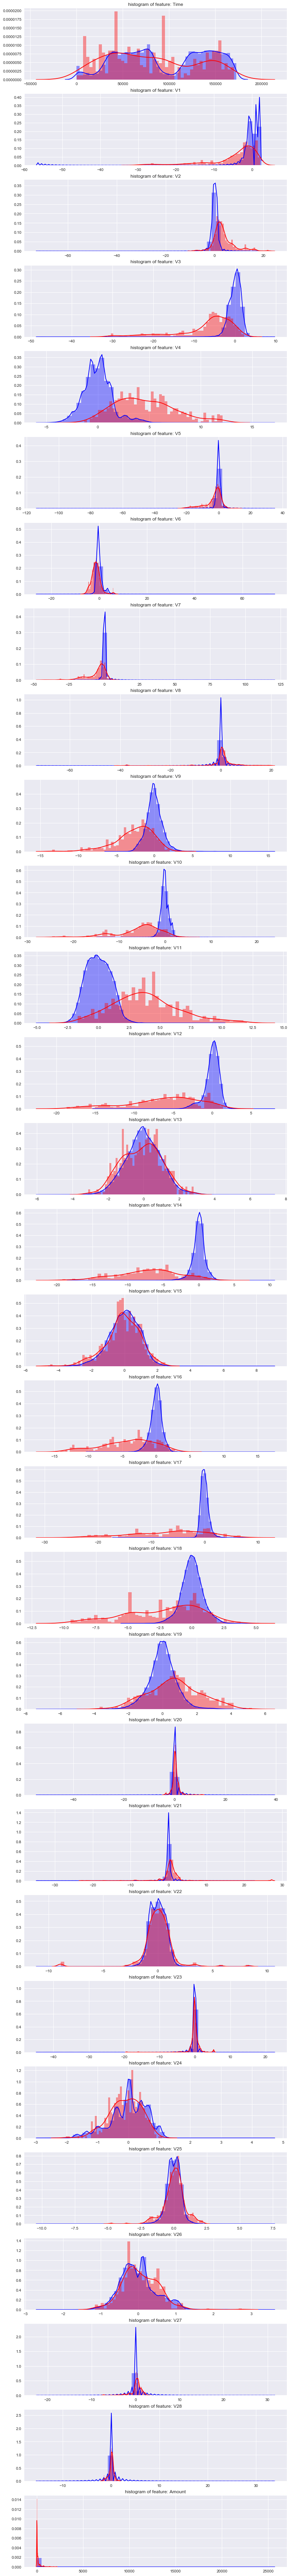

In [61]:
features = [feat for feat in credit_card.columns.values if feat not in ['Class']]
num_features = len(features)
plt.figure(figsize=(12, num_features * 4))
gs = gridspec.GridSpec(num_features, 1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(legitimate[feat], bins=50, color='b')
    sns.distplot(fraudulent[feat], bins=50, color='r')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(feat))
plt.show()

### Thoughts

The features all seem to be very normally distributed with the mean centered around 0.

Fortunately many of the feature values between legitimate and fraudulent transactions do not coincide 1:1, so there is diversity between the two populations.

There are features that seem to not provide us much information though as the distributions seem almost the same.

Depending on what we are doing, removing these can help us with our classifiers as it can help reduce noise and overfitting.

## Convenience Methods

Because we are working on a highly skewed dataset, accuracy isn't the best measurement to use.

For example if we had a "dumb" classifier that predicted everything as a legitimate transaction, our accuracy would be around 99.8% but the model would not be helpful at all!

Therefore it is helpful for us to use other measurements such as the precision, recall, and f-score.

In [14]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from scipy.stats import ttest_ind

def get_ttest_fails(a, b, threshold=0.95): 
    t, p = ttest_ind(a, b, equal_var=False)

    failing_indicies = (2 * p) > (1 - threshold)
    return a.columns.values[failing_indicies], 2 * p[failing_indicies]

def get_performance(pred, actual):
    raw_perf_scores = precision_recall_fscore_support(pred, actual)
    perf_scores = np.array(raw_perf_scores).T[:, :-1]
    
    accuracy = accuracy_score(pred, actual)
    
    return accuracy, perf_scores

def display_performance(pred, actual, title=''):     
    # Reformat so the x and y axis matches the confusion matrix orientation.
    # Also drop support since it doesn't correspond on the heatmap that higher
    # is necessarily better for a class.
    
    accuracy, perf_scores = get_performance(pred, actual)
    recall, precision, fscore = perf_scores[1]
    print 'Accuracy: %f' % accuracy
    print 'Recall: %f' % recall
    print 'Precision: %f' % precision
    print 'Fscore: %f' % fscore
    
    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(
        perf_scores,
        annot=True,
        cmap='RdBu',
        fmt='.4f',        
        vmax=1.0,
        vmin=0.0,
        xticklabels=['Recall', 'Precision', 'F-score'],
    )
    ax.set(title=title, xlabel='Performance', ylabel='True label')
    plt.show()
    
    return accuracy, perf_scores

def creditcard_split_set(credit_card, test_size=0.3):
    """
    Wraps around train_test_split and removes the 'Class' label
    
    """
    X_train, X_test, y_train, y_test = train_test_split(credit_card, credit_card['Class'], test_size=test_size)
    del X_train['Class']
    del X_test['Class']
    return X_train, X_test, y_train, y_test

def asymm_creditcard_split(credit_card, fraud_test_size=0.3, legit_test_size=0.3):
    legitimate = credit_card[credit_card['Class'] == 0]
    fraudulent = credit_card[credit_card['Class'] == 1]

    
    X_train_legit, X_test_legit, y_train_legit, y_test_legit = creditcard_split_set(
        legitimate, test_size=legit_test_size
    )

    X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = creditcard_split_set(
        fraudulent, test_size = fraud_test_size
    )

    X_train = X_train_legit.append(X_train_fraud)
    y_train = y_train_legit.append(y_train_fraud)

    X_test = X_test_legit.append(X_test_fraud)
    y_test = y_test_legit.append(y_test_fraud)
    
    return X_train, X_test, y_train, y_test

def display_best_fit(x, y, title='', xlabel='', ylabel=''):
    plt.figure(figsize=(12, 6))
    
    ax = sns.regplot(x, y, x_estimator=np.mean)
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
def display_roc_curves(experiments, y_test):
    plt.figure(figsize=(12, 6))
    for x in experiments:
        pred_probas, title = x
        fpr, tpr, _ = roc_curve(y_test, pred_probas)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='ROC %s (area = %0.4f)' % (title, roc_auc))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show() 
    
def display_precision_recall_curves(experiments, y_test):
    plt.figure(figsize=(12, 6))
    for x in experiments:
        pred_probas, title = x
        precisions, recalls, _ = precision_recall_curve(y_test, pred_probas)
        prec_rec_auc = average_precision_score(y_test, pred_probas)
        plt.plot(precisions, recalls, lw=2, label='%s (area = %0.4f)' % (title, prec_rec_auc))

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.show() 
    

## Gaussian Anomaly

For this model, we will use the property of our data being normally distributed to detect "anomalies".

The way this works is that we'll feed it a set of means and variances for features of our "good" data.

The means and standard deviations will then be used to define the normal distribution for the features of our data.

For predictions, it will take the features of each transaction and calculate the "probability" of such a transaction occurring. We will then threshold the probabilities on what we determine to be acceptable.

Anything below the threshold will be flagged as a fraudulent transaction.

Because this model relies on probability distributions, it may be helpful to remove features that do not differ much.

In order to do this, we can use the fact that the data is normally distributed allowing us to do a t-test between the features of the two populations to see that they are signficantly different.

In [15]:
class GaussianModel():
    def __init__(self, mean, var, std=None):
        self.mean = mean
        self.var = var
        if std is None:
            self.std = np.sqrt(var)
        else:
            self.std = np.sqrt(var)
            
    def fit(self, X, y):
        self.mean = X.mean()
        self.var = X.var()
        self.std = X.std()
            
    def predict(self, X):
        power_num = np.square(X - self.mean)
        power_denom = 2 * self.var

        num = np.exp(-power_num / power_denom)
        
        # Remove denominator because it is applied to every calculation so
        # all it does is scale all the probabilities by the same constant
#         denom = np.sqrt(2 * np.pi) * self.std
        denom = 1
        
        z = num / denom
        return np.prod(z, axis=1)

In [16]:
# Drop parameters that may not be particularly informative
drop_cols, _ = get_ttest_fails(legitimate, fraudulent, threshold=0.90)

trimmed_credit_cards = credit_card.drop(drop_cols, axis=1)
trimmed_legitimate = legitimate.drop(drop_cols, axis=1)
trimmed_fraudulent = fraudulent.drop(drop_cols, axis=1)

In [505]:
# We want to drop any features that don't differ much between
# legitimate and fraudulent data.
drop_cols, _ = get_ttest_fails(legitimate, fraudulent, threshold=0.75)

X_train_legit, X_test_legit, y_train_legit, y_test_legit = creditcard_split_set(
    trimmed_legitimate, test_size = 0.25
)

X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = creditcard_split_set(
    trimmed_fraudulent, test_size = 0.30
)

model = GaussianModel(X_train_legit.mean(), X_train_legit.var(), std=X_train_legit.std())

p_vals = model.predict(X_train_legit)
print p_vals.describe(percentiles=np.arange(0.01, 1, .01))

p_vals = model.predict(X_train_fraud)
print p_vals.describe(percentiles=np.arange(0.01, 1, .01))

count    2.132360e+05
mean     4.400129e-03
std      1.064167e-02
min      0.000000e+00
1%       7.675452e-44
2%       4.115699e-25
3%       1.094471e-17
4%       1.837470e-14
5%       1.152348e-12
6.0%     1.373795e-11
7.0%     9.529848e-11
8%       4.645969e-10
9%       1.545940e-09
10%      4.296018e-09
11%      9.485632e-09
12%      1.900313e-08
13%      3.554057e-08
14.0%    6.040279e-08
15.0%    9.737879e-08
16%      1.488033e-07
17%      2.191450e-07
18.0%    3.087242e-07
19%      4.325981e-07
20%      5.874637e-07
21.0%    7.820050e-07
22%      1.033725e-06
23%      1.359657e-06
24.0%    1.756124e-06
25%      2.275201e-06
26%      2.882007e-06
             ...     
71.0%    1.976562e-03
72%      2.193955e-03
73%      2.434038e-03
74%      2.699143e-03
75%      2.991505e-03
76%      3.311168e-03
77%      3.656726e-03
78%      4.036984e-03
79%      4.475795e-03
80%      4.942398e-03
81%      5.475221e-03
82%      6.078106e-03
83%      6.724487e-03
84.0%    7.446124e-03
85%      8

### Gaussian Analysis

There seems to be a class of fraudulent transactions that are highly anomalous.

Unfortunately, it also seems like many of our legitimate transactions are outliers.

Because of this it seem like separating the transaction types purely using Gaussian probability thresholds is not that promising.

For example, setting a threshold at 7.865569e-18 will give us a recall of ~85% for fraud, but in doing so we will also flag ~3% of legitimate transactions as also fraudulent.

Given the amount of legitimate transcations to fraudulent transactions, this will give us a terribly low precision for detecting fraudulent data.

This model is probably too noisy to use.

Accuracy: 0.970420
Recall: 0.858108
Precision: 0.015679
Fscore: 0.030795


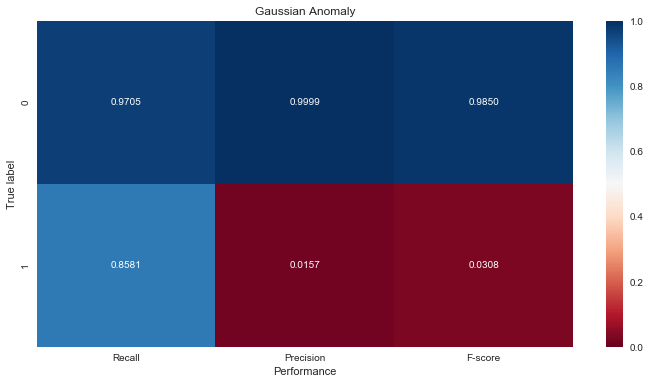

(0.97041976258843732, array([ 0.85810811,  0.01567901,  0.03079534]))

In [186]:
from sklearn.metrics import confusion_matrix

THRESHOLD = 7.865569e-18

X_test = X_test_legit.append(X_test_fraud)
y_test = y_test_legit.append(y_test_fraud)

pred = model.predict(X_test) < THRESHOLD
display_performance(pred, y_test, title='Gaussian Anomaly')

# Random Forest

## Experiment with number of trees

Allegedly the ideal number of trees is somewhere between 64-128. We should experiment and see how well that fits with our data set.

>Therefore, it is possible to suggest, based on the ex-periments, a range between 64 and 128 trees in a forest. With these numbers of treesit is possible to obtain a good balance between AUC, processing time, and memoryusage. We have also found an experimental relationship (inversely proportional)for AUC gain when doubling the number of trees in any forest 
>
>How Many Trees in a Random Forest? (PDF Download Available). Available from: https://www.researchgate.net/publication/230766603_How_Many_Trees_in_a_Random_Forest [accessed Mar 26, 2017].

In [8]:
REPEAT = 5
num_trees = (range(10, 60 + 5, 5) + range(64, 128 + 8, 8))
accuracies = []
recalls = []
precisions = []
fscores = []

for _ in range(REPEAT):
    # We will heavily undersample. This is for no good reason other
    # than to decrease the size of our training set.    
    X_train, X_test, y_train, y_test = asymm_creditcard_split(
        trimmed_credit_cards,
        fraud_test_size=0.3,
        legit_test_size=0.95
    )
    for num in num_trees:
        print 'Training random forest with %d trees' % num

        rfc = RandomForestClassifier(n_estimators=num, n_jobs=-1)
        rfc.fit(X_train, y_train)
        pred = rfc.predict(X_test)

        accuracy, perf_scores = get_performance(pred, y_test)

        accuracies.append(accuracy)
        recalls.append(perf_scores[:, 0])
        precisions.append(perf_scores[:, 1])
        fscores.append(perf_scores[:, 2])

num_trees = np.array(num_trees * REPEAT)
accuracies = np.array(accuracies)
recalls = np.array(recalls)
precisions = np.array(precisions)
fscores = np.array(fscores)


Training random forest with 10 trees
Training random forest with 15 trees
Training random forest with 20 trees
Training random forest with 25 trees
Training random forest with 30 trees
Training random forest with 35 trees
Training random forest with 40 trees
Training random forest with 45 trees
Training random forest with 50 trees
Training random forest with 55 trees
Training random forest with 60 trees
Training random forest with 64 trees
Training random forest with 72 trees
Training random forest with 80 trees
Training random forest with 88 trees
Training random forest with 96 trees
Training random forest with 104 trees
Training random forest with 112 trees
Training random forest with 120 trees
Training random forest with 128 trees
Training random forest with 10 trees
Training random forest with 15 trees
Training random forest with 20 trees
Training random forest with 25 trees
Training random forest with 30 trees
Training random forest with 35 trees
Training random forest with 40 tre

/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


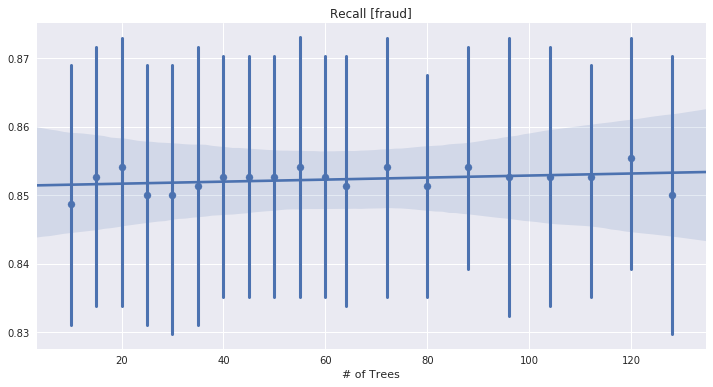

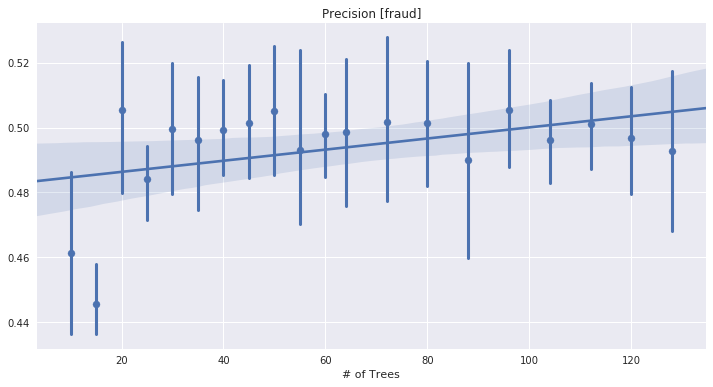

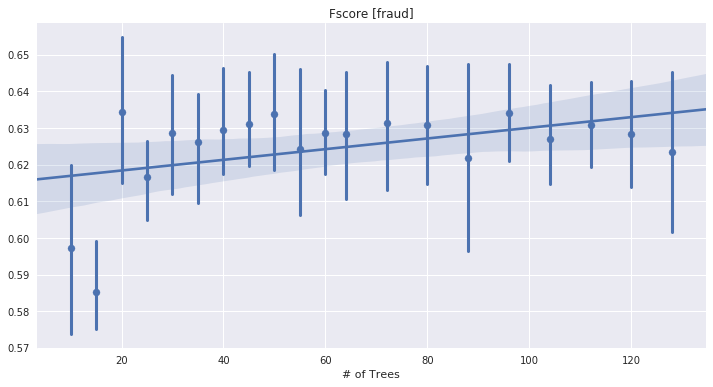

In [9]:
display_best_fit(
    num_trees,
    recalls[:, 1],
    title='Recall [fraud]',
    xlabel='# of Trees'
)
display_best_fit(
    num_trees,
    precisions[:, 1],
    title='Precision [fraud]',
    xlabel='# of Trees'
)
display_best_fit(
    num_trees,
    fscores[:, 1],
    title='Fscore [fraud]',
    xlabel='# of Trees'
)


## Number of trees analysis

It seems like for our dataset, the performance of a random forest classifier on average is fairly consistent across all number of trees greater than 40.

Although there does not seem to be much change, we are also running on a smaller dataset so we should choose 128 trees just in case since it doesn't seem to hurt.

## Experiment with naive undersampling

Because the classes are heavily imbalanced, one useful technique is to undersample the majority class and / or oversample the minority class.

Fortunately our dataset is (relatively) small so we can run over the entire dataset.

In [10]:
NUM_TREES = 128
# Keep the size of our fraud training / test set constant while
# varying that of the legitimate set
REPEAT = 5

legit_test_sizes = np.arange(0, 1.0, 0.1) + 0.1
accuracies = []
recalls = []
precisions = []
fscores = []
preds = []

for _ in range(REPEAT):
    for legit_test_size in legit_test_sizes:
        X_train_legit, X_test_legit, y_train_legit, y_test_legit = creditcard_split_set(
            trimmed_legitimate, test_size=0.3
        )

        X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = creditcard_split_set(
            trimmed_fraudulent, test_size = 0.3
        )
        
        total_legit_train = X_train_legit.shape[0]
        chosen_indices = np.random.choice(
            total_legit_train,
            int(total_legit_train * legit_test_size)
        )

        X_train = X_train_legit.iloc[chosen_indices].append(X_train_fraud)
        y_train = y_train_legit.iloc[chosen_indices].append(y_train_fraud)        
        
        X_test = X_test_legit.append(X_test_fraud)
        y_test = y_test_legit.append(y_test_fraud)
        
        print 'Training random forest with %f legitimate transactions' % legit_test_size
        
        rfc = RandomForestClassifier(n_estimators=NUM_TREES, n_jobs=-1)
        rfc.fit(X_train, y_train)
        pred = rfc.predict(X_test)

        accuracy, perf_scores = get_performance(pred, y_test)

        accuracies.append(accuracy)
        recalls.append(perf_scores[:, 0])
        precisions.append(perf_scores[:, 1])
        fscores.append(perf_scores[:, 2])
        preds.append(pred)

legit_test_sizes = np.array(list(legit_test_sizes) * REPEAT)
accuracies = np.array(accuracies)
recalls = np.array(recalls)
precisions = np.array(precisions)
fscores = np.array(fscores)
preds = np.array(preds)

Training random forest with 0.100000 legitimate transactions
Training random forest with 0.200000 legitimate transactions
Training random forest with 0.300000 legitimate transactions
Training random forest with 0.400000 legitimate transactions
Training random forest with 0.500000 legitimate transactions
Training random forest with 0.600000 legitimate transactions
Training random forest with 0.700000 legitimate transactions
Training random forest with 0.800000 legitimate transactions
Training random forest with 0.900000 legitimate transactions
Training random forest with 1.000000 legitimate transactions
Training random forest with 0.100000 legitimate transactions
Training random forest with 0.200000 legitimate transactions
Training random forest with 0.300000 legitimate transactions
Training random forest with 0.400000 legitimate transactions
Training random forest with 0.500000 legitimate transactions
Training random forest with 0.600000 legitimate transactions
Training random forest w

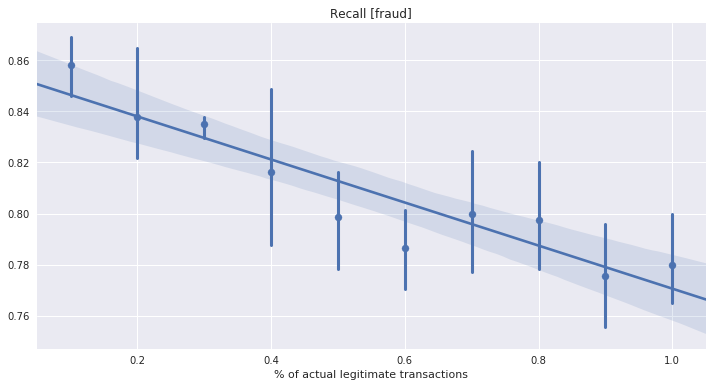

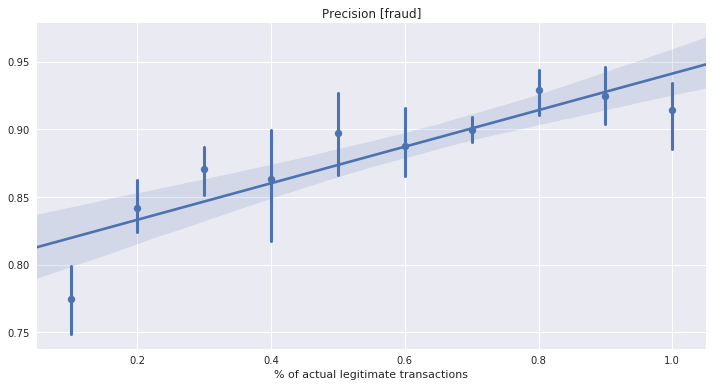

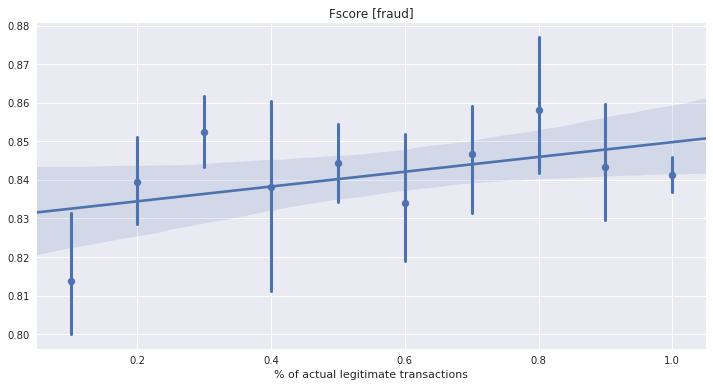

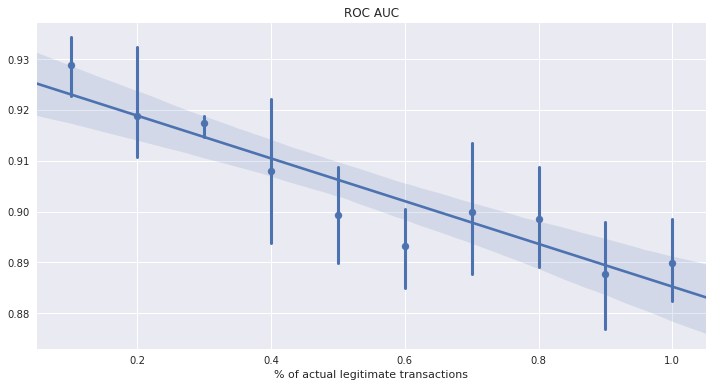

In [16]:
display_best_fit(
    legit_test_sizes,
    recalls[:, 1],
    title='Recall [fraud]',
    xlabel='% of actual legitimate transactions'
)
display_best_fit(
    legit_test_sizes,
    precisions[:, 1],
    title='Precision [fraud]',
    xlabel='% of actual legitimate transactions'
)
display_best_fit(
    legit_test_sizes,
    fscores[:, 1],
    title='Fscore [fraud]',
    xlabel='% of actual legitimate transactions'
)
display_best_fit(
    legit_test_sizes,
    np.array([roc_auc_score(y_test, p) for p in preds]),
    title='ROC AUC',
    xlabel='% of actual legitimate transactions'
)


## Naive undersampling analysis

The recall for fraudulent cases goes up the more undersampled legitimate cases are, but at the same time precision also goes down significantly in a way that does not immediately seem worth it.

## Experiment with advanced sampling

In [38]:
NUM_TREES = 128
# Use the same dataset for the following two experiment sections below
X_train_legit, X_test_legit, y_train_legit, y_test_legit = creditcard_split_set(
    legitimate, test_size=0.3
)

X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = creditcard_split_set(
    fraudulent, test_size = 0.3
)


In [39]:
X_train = X_train_legit.append(X_train_fraud)
y_train = y_train_legit.append(y_train_fraud)        

X_test = X_test_legit.append(X_test_fraud)
y_test = y_test_legit.append(y_test_fraud)

# Collect all results to display results side by side
advanced_sampling_results = []

### Undersampling with Tomek links

Accuracy: 0.999508
Recall: 0.756757
Precision: 0.949153
Fscore: 0.842105


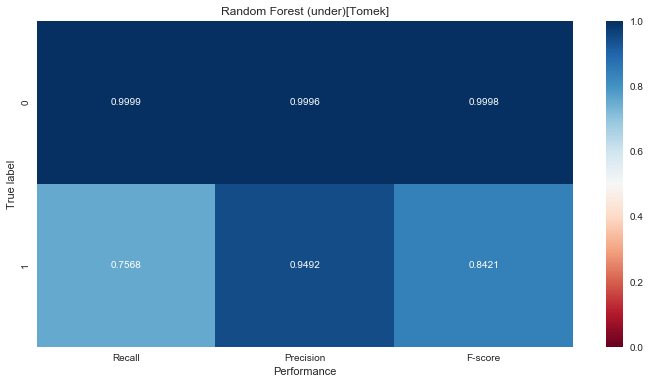

In [40]:
tl = TomekLinks()
rs_X_train, rs_y_train = tl.fit_sample(X_train, y_train)

rs_X_train = pd.DataFrame(rs_X_train)
rs_X_train.columns = X_train.columns.values

rfc = RandomForestClassifier(n_estimators=NUM_TREES, n_jobs=-1)
rfc.fit(rs_X_train, rs_y_train)

pred = np.array(rfc.predict_proba(X_test))[:, 1]

title = 'Random Forest (under)[Tomek]'
results = display_performance((pred > 0.5).astype(int), y_test, title=title)
advanced_sampling_results.append(results + (title, pred,))


### Oversampling with SMOTE

Accuracy: 0.999485
Recall: 0.777027
Precision: 0.912698
Fscore: 0.839416


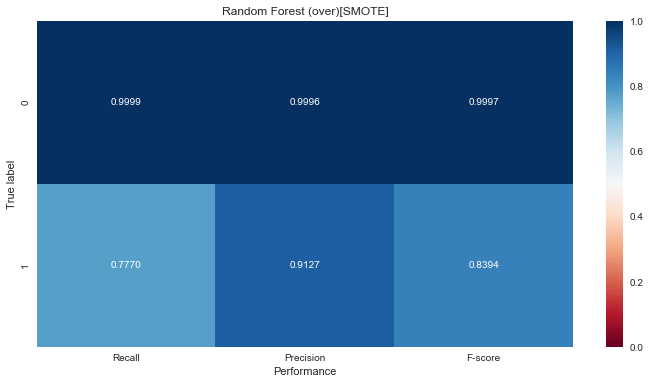

In [41]:
sm = SMOTE(kind='regular')
rs_X_train, rs_y_train = sm.fit_sample(X_train, y_train)

rs_X_train = pd.DataFrame(rs_X_train)
rs_X_train.columns = X_train.columns.values

rfc = RandomForestClassifier(n_estimators=NUM_TREES, n_jobs=-1)
rfc.fit(rs_X_train, rs_y_train)

pred = np.array(rfc.predict_proba(X_test))[:, 1]

title = 'Random Forest (over)[SMOTE]'
results = display_performance((pred > 0.5).astype(int), y_test, title=title)
advanced_sampling_results.append(results + (title, pred,))


### Hybrid with Tomek links + SMOTE

Accuracy: 0.999485
Recall: 0.777027
Precision: 0.912698
Fscore: 0.839416


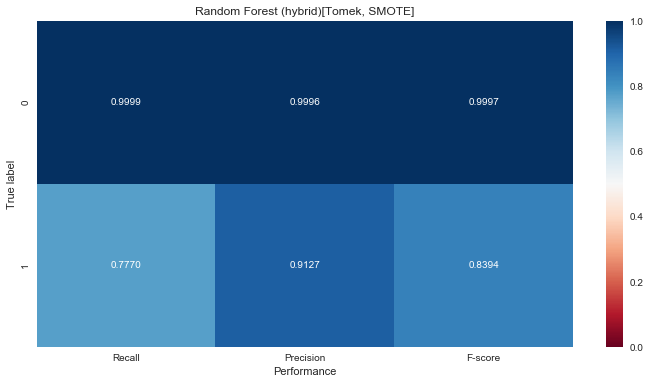

In [42]:
tl = TomekLinks()
rs_X_train, rs_y_train = tl.fit_sample(X_train, y_train)

sm = SMOTE(kind='regular')
rs_X_train, rs_y_train = sm.fit_sample(rs_X_train, rs_y_train)

rs_X_train = pd.DataFrame(rs_X_train)
rs_X_train.columns = X_train.columns.values

rfc = RandomForestClassifier(n_estimators=NUM_TREES, n_jobs=-1)
rfc.fit(rs_X_train, rs_y_train)

pred = np.array(rfc.predict_proba(X_test))[:, 1]

title = 'Random Forest (hybrid)[Tomek, SMOTE]'
results = display_performance((pred > 0.5).astype(int), y_test, title=title)
advanced_sampling_results.append(results + (title, pred,))


### Hybrid with SMOTE + Tomek links

Accuracy: 0.999462
Recall: 0.770270
Precision: 0.904762
Fscore: 0.832117


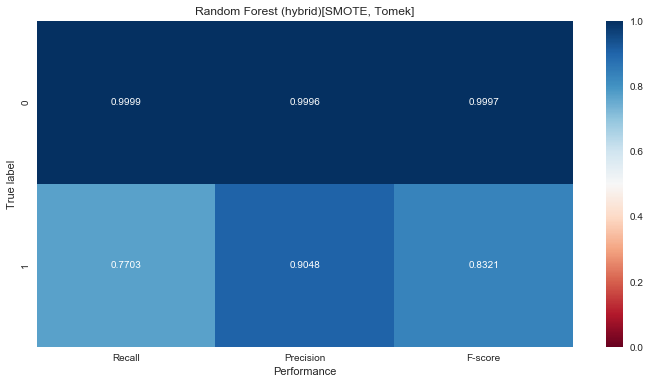

In [43]:
sm = SMOTE(kind='regular')
rs_X_train, rs_y_train = sm.fit_sample(X_train, y_train)

tl = TomekLinks()
rs_X_train, rs_y_train = tl.fit_sample(rs_X_train, rs_y_train)

rs_X_train = pd.DataFrame(rs_X_train)
rs_X_train.columns = X_train.columns.values

rfc = RandomForestClassifier(n_estimators=NUM_TREES, n_jobs=-1)
rfc.fit(rs_X_train, rs_y_train)

pred = np.array(rfc.predict_proba(X_test))[:, 1]

title = 'Random Forest (hybrid)[SMOTE, Tomek]'
results = display_performance((pred > 0.5).astype(int), y_test, title=title)
advanced_sampling_results.append(results + (title, pred,))


### Control

Accuracy: 0.999508
Recall: 0.756757
Precision: 0.949153
Fscore: 0.842105


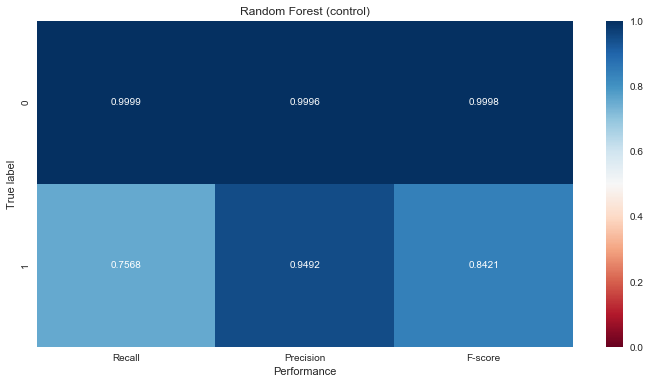

In [44]:
rfc = RandomForestClassifier(n_estimators=NUM_TREES, n_jobs=-1)
rfc.fit(X_train, y_train)

pred = np.array(rfc.predict_proba(X_test))[:, 1]

title = 'Random Forest (control)'
results = display_performance((pred > 0.5).astype(int), y_test, title=title)
advanced_sampling_results.append(results + (title, pred,))


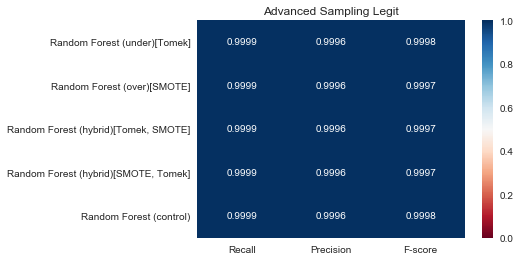

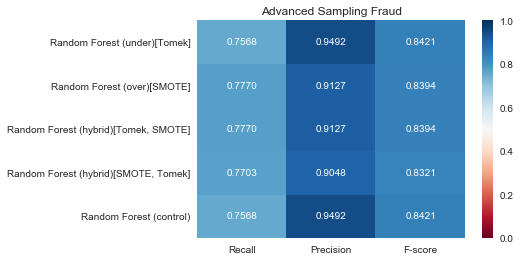

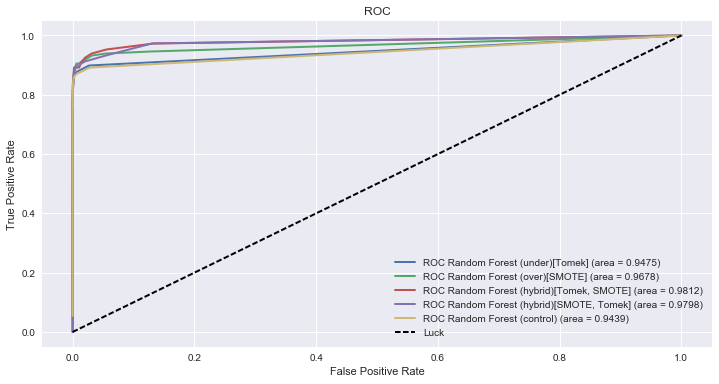

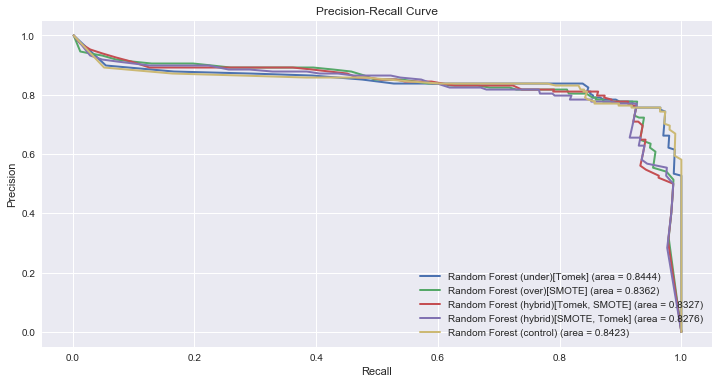

In [45]:
accuracies = [res[0] for res in advanced_sampling_results]
perf_scores = [res[1] for res in advanced_sampling_results]
titles = [res[2] for res in advanced_sampling_results]
preds = [res[3] for res in advanced_sampling_results]

perf_scores = np.array(perf_scores)

ax = sns.heatmap(
    perf_scores[:, 0],
    annot=True,
    cmap='RdBu',
    fmt='.4f',
    vmax=1.0,
    vmin=0.0,
    yticklabels=titles,
    xticklabels=['Recall', 'Precision', 'F-score'],    
)
ax.set(title= 'Advanced Sampling Legit')
plt.show()

ax = sns.heatmap(
    perf_scores[:, 1],
    annot=True,
    cmap='RdBu',    
    fmt='.4f', 
    vmax=1.0,
    vmin=0.0,
    yticklabels=titles,
    xticklabels=['Recall', 'Precision', 'F-score'],    
)
ax.set(title= 'Advanced Sampling Fraud')
plt.show()


display_roc_curves(zip(preds, titles), y_test)

display_precision_recall_curves(zip(preds, titles), y_test)

## Advanced sampling with naive undersampling

In [46]:
total_legit_train = X_train_legit.shape[0]
chosen_indices = np.random.choice(
    total_legit_train,
    int(total_legit_train * .10)
)

X_train = X_train_legit.iloc[chosen_indices].append(X_train_fraud)
y_train = y_train_legit.iloc[chosen_indices].append(y_train_fraud)        

X_test = X_test_legit.append(X_test_fraud)
y_test = y_test_legit.append(y_test_fraud)

# Collect all results to display results side by side
undersample_advanced_sampling_results = []

### Undersampling with Tomek links

Accuracy: 0.999321
Recall: 0.817568
Precision: 0.796053
Fscore: 0.806667


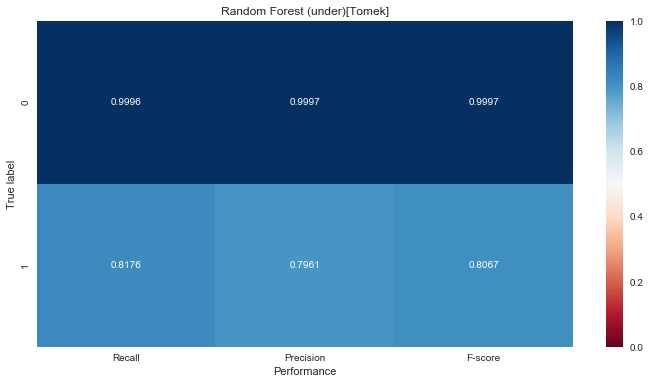

In [47]:
tl = TomekLinks()
rs_X_train, rs_y_train = tl.fit_sample(X_train, y_train)

rs_X_train = pd.DataFrame(rs_X_train)
rs_X_train.columns = X_train.columns.values

rfc = RandomForestClassifier(n_estimators=NUM_TREES, n_jobs=-1)
rfc.fit(rs_X_train, rs_y_train)

pred = np.array(rfc.predict_proba(X_test))[:, 1]

title = 'Random Forest (under)[Tomek]'
results = display_performance((pred > 0.5).astype(int), y_test, title=title)
undersample_advanced_sampling_results.append(results + (title, pred,))

### Oversampling with SMOTE

Accuracy: 0.999005
Recall: 0.817568
Precision: 0.675978
Fscore: 0.740061


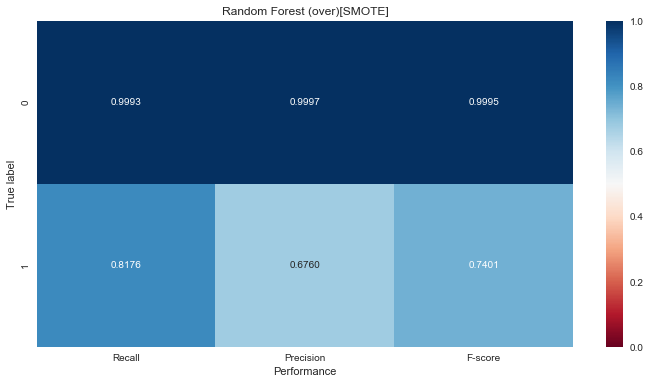

In [48]:
sm = SMOTE(kind='regular')
rs_X_train, rs_y_train = sm.fit_sample(X_train, y_train)

rs_X_train = pd.DataFrame(rs_X_train)
rs_X_train.columns = X_train.columns.values

rfc = RandomForestClassifier(n_estimators=NUM_TREES, n_jobs=-1)
rfc.fit(rs_X_train, rs_y_train)

pred = np.array(rfc.predict_proba(X_test))[:, 1]

title = 'Random Forest (over)[SMOTE]'
results = display_performance((pred > 0.5).astype(int), y_test, title=title)
undersample_advanced_sampling_results.append(results + (title, pred,))


### Hybrid with Tomek links + SMOTE

Accuracy: 0.998970
Recall: 0.824324
Precision: 0.663043
Fscore: 0.734940


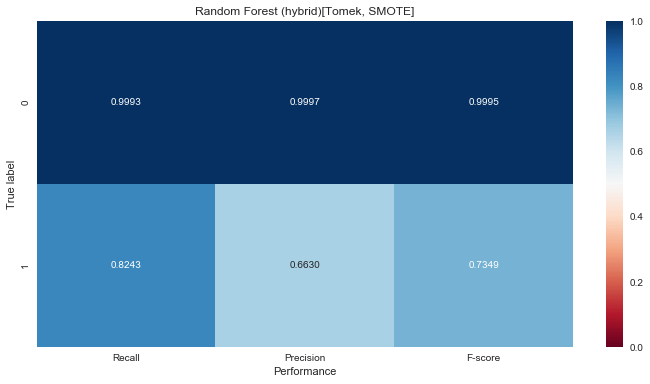

In [49]:
tl = TomekLinks()
rs_X_train, rs_y_train = tl.fit_sample(X_train, y_train)

sm = SMOTE(kind='regular')
rs_X_train, rs_y_train = sm.fit_sample(rs_X_train, rs_y_train)

rs_X_train = pd.DataFrame(rs_X_train)
rs_X_train.columns = X_train.columns.values

rfc = RandomForestClassifier(n_estimators=NUM_TREES, n_jobs=-1)
rfc.fit(rs_X_train, rs_y_train)

pred = np.array(rfc.predict_proba(X_test))[:, 1]

title = 'Random Forest (hybrid)[Tomek, SMOTE]'
results = display_performance((pred > 0.5).astype(int), y_test, title=title)
undersample_advanced_sampling_results.append(results + (title, pred,))


### Hybrid with SMOTE + Tomek links

Accuracy: 0.999075
Recall: 0.817568
Precision: 0.699422
Fscore: 0.753894


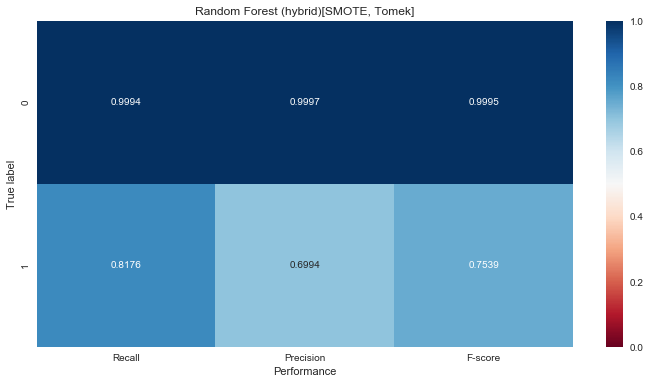

In [50]:
sm = SMOTE(kind='regular')
rs_X_train, rs_y_train = sm.fit_sample(X_train, y_train)

tl = TomekLinks()
rs_X_train, rs_y_train = tl.fit_sample(rs_X_train, rs_y_train)

rs_X_train = pd.DataFrame(rs_X_train)
rs_X_train.columns = X_train.columns.values

rfc = RandomForestClassifier(n_estimators=NUM_TREES, n_jobs=-1)
rfc.fit(rs_X_train, rs_y_train)

pred = np.array(rfc.predict_proba(X_test))[:, 1]

title = 'Random Forest (hybrid)[SMOTE, Tomek]'
results = display_performance((pred > 0.5).astype(int), y_test, title=title)
undersample_advanced_sampling_results.append(results + (title, pred,))


### Control

Accuracy: 0.999345
Recall: 0.810811
Precision: 0.810811
Fscore: 0.810811


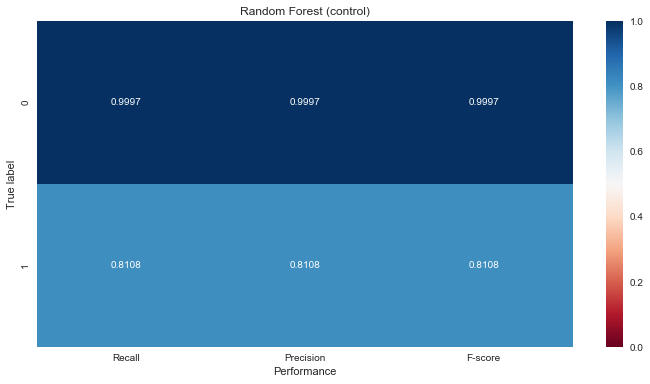

In [51]:
rfc = RandomForestClassifier(n_estimators=NUM_TREES, n_jobs=-1)
rfc.fit(X_train, y_train)

pred = np.array(rfc.predict_proba(X_test))[:, 1]

title = 'Random Forest (control)'
results = display_performance((pred > 0.5).astype(int), y_test, title=title)
undersample_advanced_sampling_results.append(results + (title, pred,))

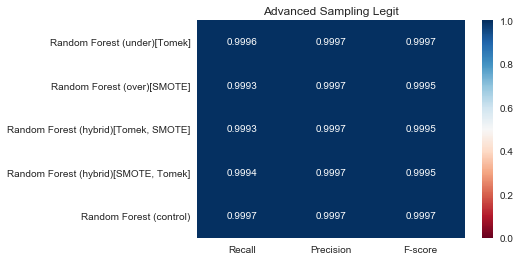

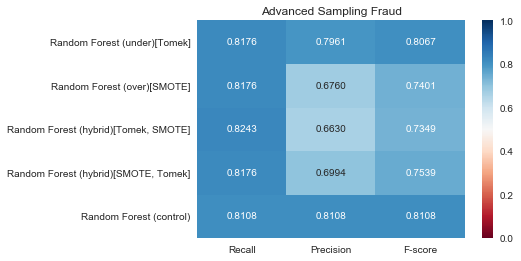

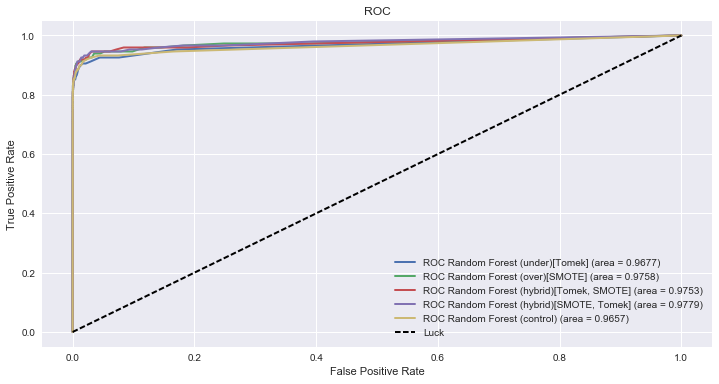

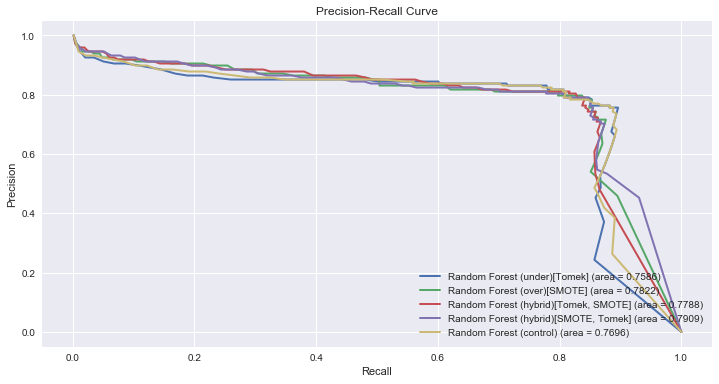

In [52]:
accuracies = [res[0] for res in undersample_advanced_sampling_results]
perf_scores = [res[1] for res in undersample_advanced_sampling_results]
titles = [res[2] for res in undersample_advanced_sampling_results]
preds = [res[3] for res in undersample_advanced_sampling_results]

perf_scores = np.array(perf_scores)

ax = sns.heatmap(
    perf_scores[:, 0],
    annot=True,
    cmap='RdBu',
    fmt='.4f',
    vmax=1.0,
    vmin=0.0,
    yticklabels=titles,
    xticklabels=['Recall', 'Precision', 'F-score'],    
)
ax.set(title= 'Advanced Sampling Legit')
plt.show()

ax = sns.heatmap(
    perf_scores[:, 1],
    annot=True,
    cmap='RdBu',    
    fmt='.4f', 
    vmax=1.0,
    vmin=0.0,
    yticklabels=titles,
    xticklabels=['Recall', 'Precision', 'F-score'],    
)
ax.set(title= 'Advanced Sampling Fraud')
plt.show()


display_roc_curves(zip(preds, titles), y_test)

display_precision_recall_curves(zip(preds, titles), y_test)

## Advanced sampling analysis

Applying SMOTE seems to improve our recall rate.

Unfortunately our precision appears to decrease. Ideally we could get more fraudulent data to provide to our model to possibly establish a cleaner boundary. This is not an option however.

In general though the minor increase in f-score and roc-auc makes it seem worth exploring.

Naive undersampling prior to applying more advanced sampling techniques once again does not seem worth it due to the dramatic drop in precision which is especially visible in the precision-recall curve.

## Testing

Given current search, it seems promising to apply SMOTE to our data set, lets apply and run this data over multiple models

In [23]:
## Everything below has already been run at some point above, but we
# are just centralizing everything here and redoing these operations
# in case readers jumped straight to this section.

NUM_TREES = 128

# Standardize the data for classification models that rely
# on gradient descent, which can get noisy if different scales involved
standardized_credit_cards = (credit_card - credit_card.mean()) / credit_card.std()
# Except for Class!
standardized_credit_cards['Class'] = (standardized_credit_cards['Class'] > 0).astype(int)

# Use the same dataset for the following experiments below
X_train, X_test, y_train, y_test = creditcard_split_set(
    standardized_credit_cards, test_size=0.3
)

# Oversample the minority class
sm = SMOTE(kind='regular')
rs_X_train, rs_y_train = sm.fit_sample(X_train, y_train)

rs_X_train = pd.DataFrame(rs_X_train)
rs_X_train.columns = X_train.columns.values

# Collect all test results here
testing_results = []

Accuracy: 0.999602
Recall: 0.838710
Precision: 0.935252
Fscore: 0.884354


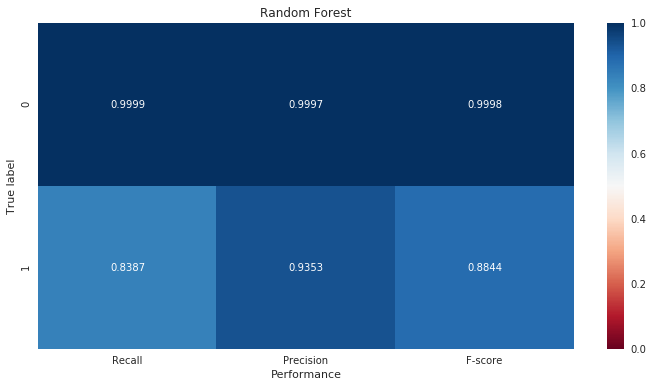

In [24]:
rfc = RandomForestClassifier(n_estimators=NUM_TREES, n_jobs=-1)
rfc.fit(rs_X_train, rs_y_train)

pred=np.array(rfc.predict_proba(X_test))[:, 1]

title = 'Random Forest'
results = display_performance((pred > 0.5).astype(int), y_test, title=title)
testing_results.append(results + (title, pred,))


Iteration 1, loss = 0.01913273
Iteration 2, loss = 0.00334258
Iteration 3, loss = 0.00266849
Iteration 4, loss = 0.00215158
Iteration 5, loss = 0.00200505
Iteration 6, loss = 0.00174239
Iteration 7, loss = 0.00155812
Iteration 8, loss = 0.00149072
Iteration 9, loss = 0.00130388
Iteration 10, loss = 0.00111912
Iteration 11, loss = 0.00139959
Iteration 12, loss = 0.00103120
Iteration 13, loss = 0.00084728
Iteration 14, loss = 0.00122777
Iteration 15, loss = 0.00082516
Iteration 16, loss = 0.00095272
Iteration 17, loss = 0.00086812
Iteration 18, loss = 0.00067725
Iteration 19, loss = 0.00091285
Iteration 20, loss = 0.00098175
Iteration 21, loss = 0.00065234
Iteration 22, loss = 0.00097380
Iteration 23, loss = 0.00053165
Iteration 24, loss = 0.00056963
Iteration 25, loss = 0.00096231
Iteration 26, loss = 0.00049737
Iteration 27, loss = 0.00061349
Iteration 28, loss = 0.00056576
Iteration 29, loss = 0.00075350
Training loss did not improve more than tol=0.000000 for two consecutive epochs. 

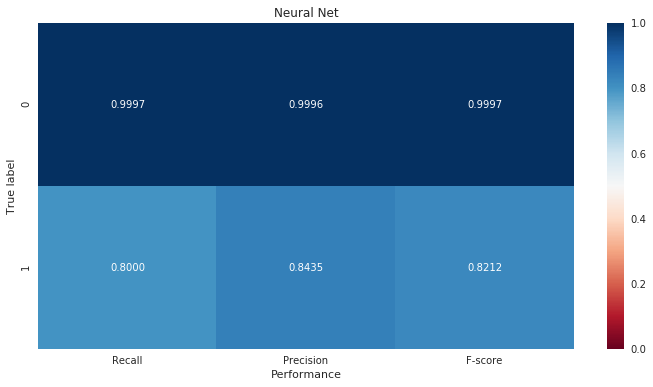

In [38]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(tol=1e-8, hidden_layer_sizes=(200, 100,), verbose=True)
mlp.fit(rs_X_train, rs_y_train)

pred=np.array(mlp.predict_proba(X_test))[:, 1]

title = 'Neural Net'
results = display_performance((pred > 0.5).astype(int), y_test, title=title)
testing_results.append(results + (title, pred,))


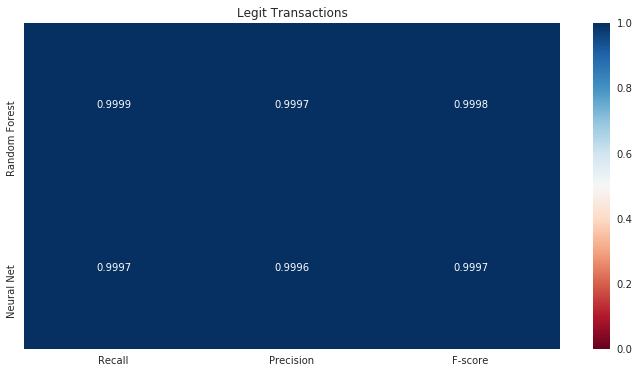

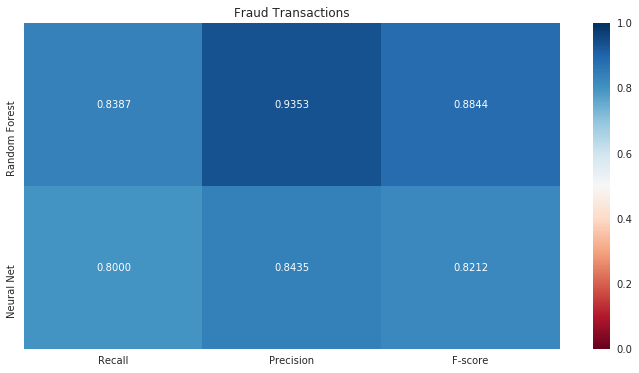

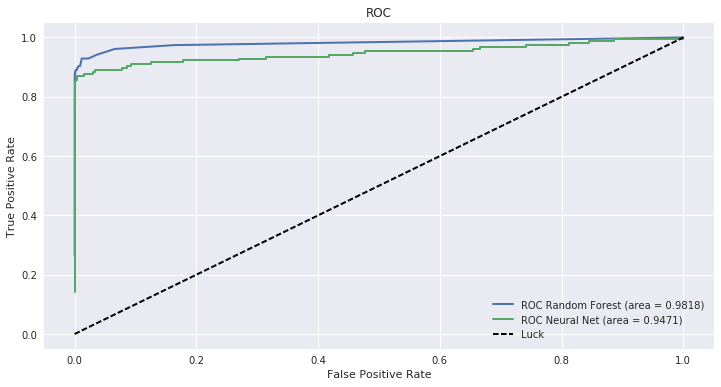

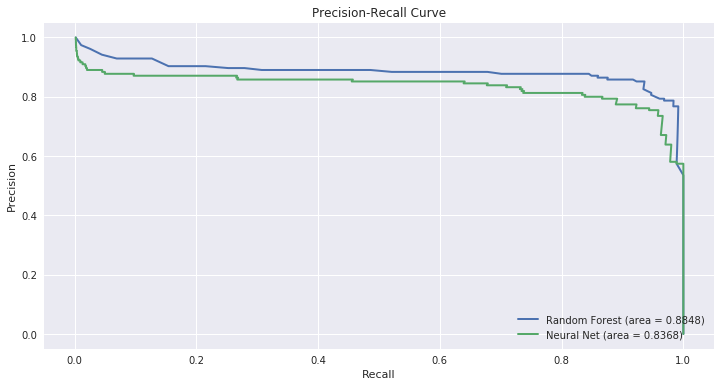

In [40]:
accuracies = [res[0] for res in testing_results]
perf_scores = [res[1] for res in testing_results]
titles = [res[2] for res in testing_results]
preds = [res[3] for res in testing_results]

perf_scores = np.array(perf_scores)

# For legitimate transactions
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    perf_scores[:, 0],
    annot=True,
    cmap='RdBu',
    fmt='.4f',
    vmax=1.0,
    vmin=0.0,
    yticklabels=titles,
    xticklabels=['Recall', 'Precision', 'F-score'],    
)
ax.set(title= 'Legit Transactions')
plt.show()

# For fraudulent transactions
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    perf_scores[:, 1],
    annot=True,
    cmap='RdBu',    
    fmt='.4f', 
    vmax=1.0,
    vmin=0.0,
    yticklabels=titles,
    xticklabels=['Recall', 'Precision', 'F-score'],    
)
ax.set(title= 'Fraud Transactions')
plt.show()

display_roc_curves(zip(preds, titles), y_test)

display_precision_recall_curves(zip(preds, titles), y_test)

## Conclusion

The dataset was split 70:30 for training and testing.

SMOTE was applied on the training set to establish a 1:1 ratio prior to being given to the models.

Results, (50% threshold where applicable):

| Model         | Accuracy | Precision | Recall | PR-AUC | ROC-AUC |
|---------------|----------|-----------|--------|--------|---------|
| Random Forest | 0.9996   | 0.9352    | 0.8387 | 0.8845 | 0.9818  |
| Neural Net    | 0.9994   | 0.8435    | 0.8000 | 0.8368 | 0.9471  |


The most successful model was a random forest with 128 trees.

However the neural net shows promise. Although it is underperforming our random forest somewhat, much time was spent on optimizing conditions for the random forest.

As a result it is possible the neural net may improve with finer tuning.

In addition, the dataset is still relatively small, so if we were able to get more examples of fraudulent data, it is possible the neural net will be more performant and efficient in the long run.

For now at least, the random forest produces a fairly suitable model at both catching fraudulent transactions while not causing too much annoyance for customers making legitimate transactions.